In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

from siuba import *
import pandas as pd
import geopandas as gpd
import datetime as dt

from rt_analysis import rt_parser
from rt_analysis import rt_filter_map_plot

from shared_utils import rt_utils, rt_dates

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_329/2561973901.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  im

# Checking if intermediate data is available

   * First, decide on a date of interest. Let's use May 17, 2023
   * The rt_utils.get_operators function takes the analysis date as a datetime.date object, which we'll construct below
   * It also takes a list of operators (currently itp_ids) of interest
   * Let's start with Big Blue Bus (300)

In [4]:
analysis_date = dt.date(2023, 5, 17)

In [5]:
rt_utils.get_operators(analysis_date, [300])

{300: 'already_ran'}

In [6]:
rt_utils.get_operators(dt.date(2022, 12, 31), [300])

{300: 'not_yet_run'}

Function returns a dictionary of the status of each itp_id passed (in addition to printing it out).

# Generating intermediate data

We can process raw data for a given date and feed directly using `rt_parser.OperatorDayAnalysis`. Let's also give the function a tqdm progress bar using the `pbar` attribute.

Raw data is now only available for dates in `rt_dates`, since we use a coordinated download of vehicle positions data.

_if you're running this notebook yourself, this operator might be already ran! feel free to try another if you're curious about the generation process, or skip to the next section._

In [5]:
from tqdm.notebook import tqdm

In [6]:
pbar = tqdm()

0it [00:00, ?it/s]

In [7]:
rt_parser.OperatorDayAnalysis?

Init signature: rt_parser.OperatorDayAnalysis(itp_id, analysis_date, pbar=None)
Docstring:     
New top-level class for rt delay/speed analysis of a single operator on a single day
    
File:           ~/data-analyses/rt_delay/rt_analysis/rt_parser.py
Type:           type
Subclasses:     


In [8]:
%%capture --no-stdout
rt_day = rt_parser.OperatorDayAnalysis(300, analysis_date, pbar) # don't worry about the CRS not set UserWarning

found parquet
found parquet
found parquet
found parquet
found parquet


Then, we can save the intermediate data created with the `OperatorDayAnalysis.export_views_gcs()` method

In [9]:
rt_day.export_views_gcs()

# Generate a speedmap with RtFilterMapper

   * First, we'll construct an `RtFilterMapper` object from intermediate data using `rt_filter_map_plot.from_gcs()`
   * Be sure to check first with `rt_utils.get_operators` that data is available. Otherwise, you'll get an error

In [7]:
rt_filter_map_plot.from_gcs?

Signature: rt_filter_map_plot.from_gcs(itp_id, analysis_date, pbar=None)
Docstring:
Generates RtFilterMapper from cached artifacts in GCS. Generate using rt_parser.OperatorDayAnalysis.export_views_gcs()
    
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      function

In [8]:
rt_day = rt_filter_map_plot.from_gcs(300, analysis_date)

found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_300_2023-05-17.parquet


In [9]:
no_data = rt_filter_map_plot.from_gcs(300, dt.date(2022, 12, 20)) #we haven't ran this date, so this will give an error

FileNotFoundError: calitp-analytics-data/data-analyses/rt_delay/rt_trips/300_2022-12-20.parquet

## Key Attributes: information and dataframes

`RtFilterMapper` makes various information available as attributes, including the agency name and itp_id. The rt_trips and stop_delay_view (geo)dataframes loaded from GCS are also present, additionally `RtFilterMapper` calculates additional views such as endpoint_delay_view and endpoint_delay_summary.

These core views are _not_ changed by any filter you set, but they can be filtered manually if desired.

In [13]:
rt_day.organization_name

'City of Santa Monica'

In [14]:
rt_day.calitp_itp_id

300

In [15]:
rt_day.rt_trips >> head(3)

,feed_key,trip_key,gtfs_dataset_key,service_date,trip_id,route_id,route_short_name,shape_id,direction_id,route_type,route_long_name,route_desc,calitp_itp_id,median_time,direction,mean_speed_mph,organization_name,caltrans_district
0,dd0281dab930de28114c82dddba7a33a,2eb2a98b53edc05f0b35e4fdc9347bcb,dbbe8ee4864a2715a40749605395d584,2023-05-17,904439,3612,9,26372,0,3,Pacific Palisades,None,300,12:59:59,Northbound,9.295910,City of Santa Monica,07 - Los Angeles
1,dd0281dab930de28114c82dddba7a33a,820a431ba2afef6cf0b31e5bbcaceabc,dbbe8ee4864a2715a40749605395d584,2023-05-17,904756,3614,R12,26381,1,3,Venice/Westwood Sta/UCLA Rapid,None,300,10:47:41,Southbound,12.041539,City of Santa Monica,07 - Los Angeles
2,dd0281dab930de28114c82dddba7a33a,78be16159683ab5ba9d1cec6d5542595,dbbe8ee4864a2715a40749605395d584,2023-05-17,904083,3610,7,26363,1,3,Pico Blvd,None,300,16:35:58,Westbound,10.067814,City of Santa Monica,07 - Los Angeles


In [16]:
rt_day.stop_delay_view >> head(3)

,stop_id,stop_name,geometry,shape_id,shape_meters,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds
0,436,4TH NB & HOLLISTER NS,POINT (140103.762 -444404.496),26398,7084.624283,905380,19.0,2023-05-17 19:20:33,3619,18,0.0,2023-05-17 19:18:04.265086,0.0
1,161,MONTANA EB & 26TH FS,POINT (140018.171 -440434.232),26398,12673.256681,905380,38.0,2023-05-17 19:39:13,3619,18,0.0,2023-05-17 19:36:57.620327,0.0
2,570,MONTANA EB & STANFORD NS,POINT (140332.137 -440127.886),26398,13111.907676,905380,39.0,2023-05-17 19:40:26,3619,18,0.0,2023-05-17 19:37:52.932611,0.0


In [17]:
rt_day.endpoint_delay_summary >> head(3)

,direction_id,route_id,arrival_hour,n_trips,mean_end_delay_seconds
0,0.0,3604,5.0,1,0.00
1,0.0,3604,6.0,4,25.25
2,0.0,3604,7.0,4,202.50


In [18]:
rt_day.endpoint_delay_view >> head(3)

,stop_id,stop_name,geometry,shape_id,shape_meters,trip_id,stop_sequence,arrival_time,route_id,route_short_name,direction_id,actual_time,delay_seconds,arrival_hour,mean_speed_mph
0,1616,KINROSS EB & VETERAN FS,POINT (143310.752 -438392.060),26398,17478.709358,905380,48.0,2023-05-17 19:53:45,3619,18,0.0,2023-05-17 20:31:23.383358,2258.0,19.0,4.412566
1,1606,GAYLEY NB & STRATHMORE NS,POINT (143181.719 -437407.205),26398,18602.758227,905369,51.0,2023-05-17 16:04:01,3619,18,0.0,2023-05-17 16:26:04.106264,1323.0,16.0,7.569351
2,1606,GAYLEY NB & STRATHMORE NS,POINT (143181.719 -437407.205),26398,18602.758227,905377,51.0,2023-05-17 12:01:17,3619,18,0.0,2023-05-17 12:11:51.311770,634.0,12.0,9.858018


## Setting filter and generating a map

To set a filter, provide at least one arguement to `set_filter`. Once set, most maps, charts, and descriptions produced by RtFilterMapper will automatically apply this filter.

In [19]:
rt_day.set_filter?

Signature:
rt_day.set_filter(
    start_time=None,
    end_time=None,
    route_names=None,
    shape_ids=None,
    direction_id=None,
    direction=None,
    trip_ids=None,
    route_types=None,
)
Docstring:
start_time, end_time: string %H:%M, for example '11:00' and '14:00'
route_names: list or pd.Series of route_names (GTFS route_short_name)
direction_id: '0' or '1'
direction: string 'Northbound', 'Eastbound', 'Southbound', 'Westbound' (experimental)
trip_ids: list or pd.Series of trip_ids (GTFS trip_ids)
route_types: list or pd.Series of route_type
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method

In [20]:
rt_day.reset_filter?

Signature: rt_day.reset_filter()
Docstring: Clear filter.
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method

Here, let's filter to the morning peak period (6-9AM) and routes 2 and R12

In [21]:
rt_day.set_filter(start_time='06:00', end_time='09:00', route_names=['2', 'R12'])

In [22]:
m = rt_day.segment_speed_map()

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:433: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:433: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [23]:
m

## Variance map (new!)

Aggregated speeds are important, but it's also helpful to understand the variation in speeds in each segment. Even if the aggregate speeds are acceptable, if some trips get through an area much faster than others, it's challenging to set a schedule that will provide a consistently good rider experience. Identifying areas of high variance can help target improvements.

This is now quantified as the ratio between 80th percentile and 20th percentile speeds, and used on the CA Transit Speed Maps tool.

In [24]:
rt_day.map_variance?

Signature: rt_day.map_variance(no_title=False, no_render=False)
Docstring:
A quick map of relative speed variance across stop segments, measured as
the ratio between the 80th percentile and 20th percentile speeds
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method

In [25]:
rt_day.map_variance()

## More performant maps via embedded app

Rather than render the maps directly in the notebook via geopandas and folium, we now have the capability to save them as compressed GeoJSON to GCS and render them in an IFrame using a [minimal web app](https://github.com/cal-itp/data-infra/tree/main/apps/maps).

This method is much more efficient, and we rely on it to maintain the quantity and quality of maps on the [CA Transit Speed Maps](https://analysis.calitp.org/rt/README.html) site.

`display_spa_map` will always show the most recent map generated with either `segment_speed_map` or `map_variance`, then saved via `map_gz_export`.

In [26]:
rt_day.map_gz_export?

Signature: rt_day.map_gz_export(map_type: str = '_20p_speeds')
Docstring:
Test exporting speed data to gcs bucket for iframe render
Will always put state highway network in state['layers'][0] 
map_type: '_20p_speeds', 'variance', or 'shn'
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method

In [27]:
%%capture
rt_day.map_gz_export()

In [28]:
rt_day.spa_map_state

{'name': 'null',
 'layers': [{'name': 'D07 State Highway Network',
   'url': 'https://storage.googleapis.com/calitp-map-tiles/speeds_2023-05-17/07_SHN.geojson.gz',
   'type': 'state_highway_network'},
  {'name': 'City of Santa Monica Vehicle Speeds May 17, 2023 (Wed)',
   'url': 'https://storage.googleapis.com/calitp-map-tiles/speeds_2023-05-17/300_AM_Peak_speeds.geojson.gz',
   'type': 'speedmap',
   'properties': {'stroked': False,
    'highlight_saturation_multiplier': 0.5,
    'tooltip_speed_key': '_20p_mph'}}],
 'lat_lon': (34.039864876941344, -118.4573163712664),
 'zoom': 13,
 'legend_url': 'https://storage.googleapis.com/calitp-map-tiles/speeds_legend.svg'}

In [29]:
rt_day.display_spa_map?

Signature: rt_day.display_spa_map(width: int = 1100, height: int = 650)
Docstring:
Display map from external simple web app in the notebook/JupyterBook context via an IFrame.
Will show most recent map set using self.map_gz_export
Width/height defaults are current best option for JupyterBook, don't change for portfolio use
width, height: int (pixels)
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method

In [30]:
rt_day.display_spa_map()

In [33]:
rt_day.map_variance(no_render=True)

In [34]:
%%capture
rt_day.map_gz_export(map_type = 'variance')

In [35]:
rt_day.display_spa_map()

## Speed variability chart

Let's say we're interested in a closer look at speed variability along route 2. `RtFilterMapper` supports a detailed speed variability chart, but we must first filter to a single shape_id.

In [26]:
# Get shape_ids associated with routes in our current filter
rt_day._filter(rt_day.rt_trips) >> distinct(_.route_short_name, _.shape_id)

,route_short_name,shape_id
0,R12,26007
1,R12,26009
2,2,25976
3,2,25979


In [27]:
# Set a new filter using shape_id
rt_day.set_filter(shape_ids=['25975'])

In [28]:
rt_day.chart_variability?

Signature:
rt_day.chart_variability(
    min_stop_seq=None,
    max_stop_seq=None,
    num_segments=None,
    no_title=False,
)
Docstring:
Chart trip speed variability, as speed between each stop segments.
stop_sequence_range: (min_stop, max_stop)
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      method


/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:368: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:368: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Text(0.5, 1.0, 'Big Blue Bus Speed Variability by Stop Segment, All Route Types, Route(s) 2, Northbound, All Day, Oct 12 (Wed)')

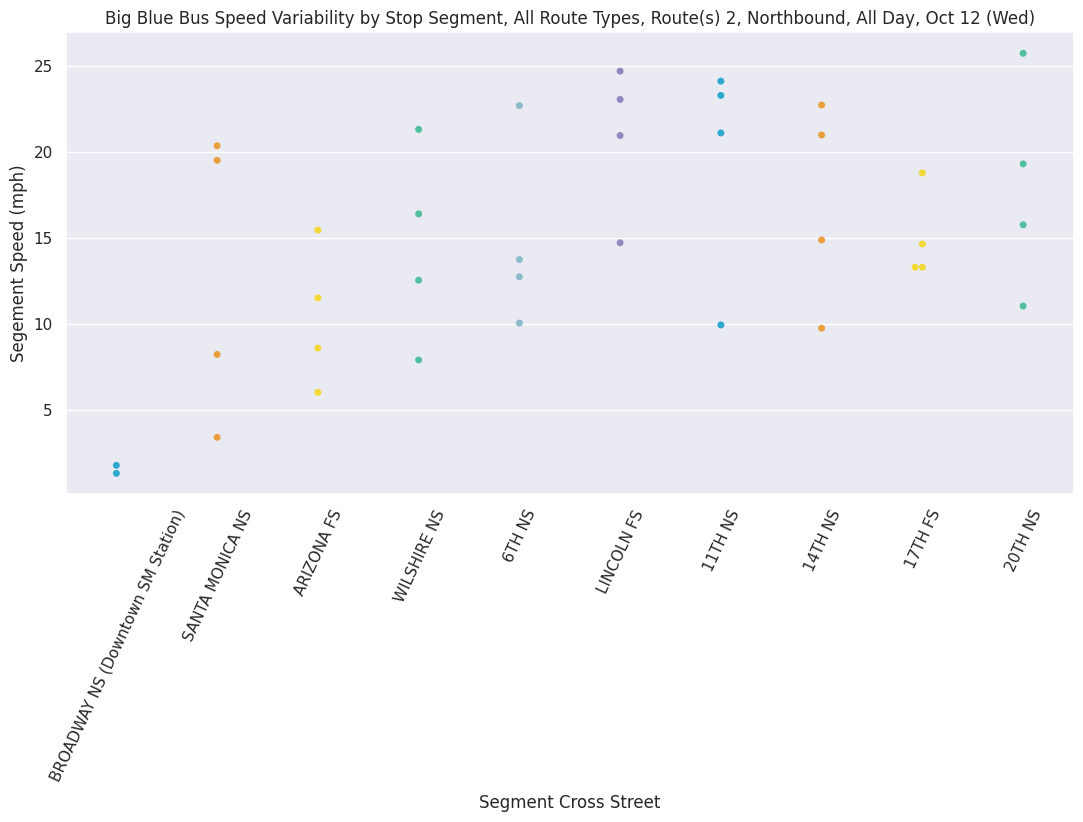

In [29]:
rt_day.chart_variability(num_segments=10)

## Corridor Metrics (for SCCP, LPP, 100 Buses, etc) 

Showing speeds on a map is great, but often it would be nice to have a reasonable estimate of how much time is lost to low speeds in a certain area -- for any combination of routes and times of day. `RtFilterMapper` includes corridor analysis methods designed to facilitate these estimates.

First, it's necessary to define the corridor. Generally, draw the corridor with a small buffer (~10 meters) around the segment you wish to measure. Note that `RtFilterMapper` currently only handles one contiguous corridor at a time. To draw the corridor, use any platform that outputs a supported GIS file format. [geojson.io](https://geojson.io) is an easy one, but you could also use ESRI or QGIS.

If using geojson.io:
* Navigate the map to your area of interest
* Click the pentagon-shaped "polygon" tool in the top center right of the map
* Construct your polygon as a series of points
* When back at the start, double-click on the starting point to finish drawing (a complete polygon will look like the screenshot below)
* Save file as geojson

![finished polygon on geojson.io](img/geojson_io.png)

### Attaching Corridor to an RtFilterMapper instance

* first, construct an `RtFilterMapper` on the date of interest as above
* use geopandas to load your corridor file as a geodataframe
* pass that geodataframe to `RtFilterMapper.add_corridor()`

In [30]:
corridor = gpd.read_file('./corridors_100buses/example_santamonica.geojson')

In [31]:
corridor

,geometry
0,"POLYGON ((-118.46334 34.04009, -118.45238 34.0..."


In [32]:
rt_day.add_corridor(corridor)

`add_corridor` finds all shapes with at least one stop within the designated corridor, and tracks all stops for those shapes starting with the stop just before entering the corridor and ending with the stop just after leaving the corridor. You can use `RtFilterMapper.quick_map_corridor()` to confirm corridor and stop locations.

In [33]:
rt_day.quick_map_corridor()

### Using Corridor for Maps and Metrics

In [34]:
# reset to remove filter from earlier
rt_day.reset_filter()

With a corridor attached, you can use the `RtFilterMapper.segment_speed_map()` `corridor` arguement to generate a speed map filtered to just the corridor.

In [35]:
rt_day.segment_speed_map(corridor=True)

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:368: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/home/jovyan/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py:368: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



#### About the Metrics

The schedule-based metric is a daily average of the sum of median trip stop delays along the corridor. To further explain, we take each corridor trip that we have data for and look at the delay in comparison to the schedule at each stop, after subtracting off any delay present as the trip entered the corridor. For each trip we then take the median delay of all stops along the corridor, and sum these medians to create the metric.

The speed-based metric is a daily average of the sum of delays for each trip traversing the corridor as compared to a reference speed of 16 miles per hour. To further explain, we take each corridor trip that we have data for and calculate the hypothetical time it would take for that trip to traverse the corridor at a speed of 16 mph. The difference between the actual time it took for the trip to traverse the corridor and that hypothetical time is the speed-based delay for that trip, and we sum those delays to create the metric. This metric is intended to provide a more consistent basis for comparison independent of scheduling practices.

In other words, if we expect a hypothetical bus lane/signal priority/payment system etc to increase corridor speeds to 16mph, this is how much time we could save per day.

With corridor attached, generate both metrics using `RtFilterMapper.corridor_metrics()`

In [36]:
rt_day.corridor_metrics()

{'schedule_metric_minutes': 193.225,
 'speed_metric_minutes': 1110.7238698817819}

`RtFilterMapper.corridor_metrics()` now supports `RtFilterMapper`'s filtering system. If the filter set excludes all corridor trips, it will raise an error.

_don't set a filter if running SCCP/LPP metrics_

In [37]:
rt_day.set_filter(shape_ids = ['26025']) # a single shape through corridor

In [38]:
rt_day.corridor_metrics()

{'schedule_metric_minutes': 0.0, 'speed_metric_minutes': 0.4808033436873188}

In [39]:
rt_day.set_filter(route_names = ['R12']) # route not near corridor

In [40]:
rt_day.corridor_metrics()

AssertionError: filter does not include any corridor trips

If running metrics for the SCCP or LPP programs, `rt_analysis` now includes a convienience function to generate the required nine-day average.

In [41]:
from rt_analysis import sccp_tools
import numpy as np

2022-2023 cycle standard SCCP/LPP date range:

In [42]:
date_range = np.arange('2022-04-30', '2022-05-09', dtype='datetime64[D]')

The next cell generates an `OperatorDayAnalysis` for each date in the range that hasn't been ran already, and saves intermediate data to gcs.

In [43]:
%%capture --no-stdout
for date in date_range:
    analysis_date = date.astype(dt.date)
    check_ran = rt_utils.get_operators(analysis_date, [300])
    if check_ran[300] == 'already_ran':
        continue
    rt_day = rt_parser.OperatorDayAnalysis(300, analysis_date, pbar)
    # don't worry about the CRS not set UserWarning
    rt_day.export_views_gcs()

already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300
already ran: 300


In [44]:
sccp_tools.sccp_average_metrics?

Signature:
sccp_tools.sccp_average_metrics(
    itp_id: int,
    date_range: <built-in function arange>,
    corridor: geopandas.geodataframe.GeoDataFrame,
    filter_dict: dict = None,
)
Docstring:
Generate averaged corridor delay metrics for SCCP, LPP programs. For 2022-2023 cycle,
default range is Apr 30 2022 to May 8 2022:
date_range = np.arange('2022-04-30', '2022-05-09', dtype='datetime64[D]')

Optional filter_dict should _not_ be used to generate SCCP/LPP metrics, but is available
for exploratory analysis and other analyses. Supply RtFilterMapper.set_filter params
as dict keys with each param's value as dict values:
filter_dict = {'start_time': '06:00', 'end_time': '10:00', 'route_names': ['2', 'R12']}
File:      ~/data-analyses/rt_delay/rt_analysis/sccp_tools.py
Type:      function


In [45]:
bbb_corridor_metrics = sccp_tools.sccp_average_metrics(itp_id=300, date_range=date_range, corridor=corridor)

found parquet
complete for date: 2022-04-30
found parquet
complete for date: 2022-05-01
found parquet
complete for date: 2022-05-02
found parquet
complete for date: 2022-05-03
found parquet
complete for date: 2022-05-04
found parquet
complete for date: 2022-05-05
found parquet
complete for date: 2022-05-06
found parquet
complete for date: 2022-05-07
found parquet
complete for date: 2022-05-08


In [46]:
bbb_corridor_metrics

{'avg_schedule_metric_minutes': 28.0,
 'avg_speed_metric_minutes': 628.0,
 'all_schedule': [31.908333333333335,
  9.841666666666667,
  0.30833333333333335,
  35.25,
  25.816666666666666,
  59.55,
  42.725,
  52.61666666666667,
  -3.566666666666667],
 'all_speed': [484.1486595413707,
  383.88234806134756,
  726.3330598415508,
  833.6681699201343,
  781.9080956422948,
  841.8386177141758,
  776.2531649614954,
  481.57557779053826,
  340.3238126351311]}

If needed, it's easy to construct a dataframe with the metrics and the date array used, to support charts or tables

In [47]:
pd.DataFrame({'dates': date_range, 'schedule_metric': bbb_corridor_metrics['all_schedule'],
'speed_metric': bbb_corridor_metrics['all_speed']})

,dates,schedule_metric,speed_metric
0,2022-04-30,31.908333,484.148660
1,2022-05-01,9.841667,383.882348
2,2022-05-02,0.308333,726.333060
3,2022-05-03,35.250000,833.668170
4,2022-05-04,25.816667,781.908096
5,2022-05-05,59.550000,841.838618
6,2022-05-06,42.725000,776.253165
7,2022-05-07,52.616667,481.575578
8,2022-05-08,-3.566667,340.323813
